In [1]:
import os
import wx
app = wx.App()
backend = __import__("Integration")
t1 = backend.turtle_setup()
home = (0,0)

In [2]:
class TabOne(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        img = wx.Image(500, 500)
        self.imageCtrl = wx.StaticBitmap(self, wx.ID_ANY, wx.Bitmap(img))
        
class TabTwo(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        self.GCODE = wx.TextCtrl(self, style = wx.TE_READONLY | wx.TE_MULTILINE)
        
        bsizer = wx.BoxSizer()
        bsizer.Add(self.GCODE, 1, wx.EXPAND)
        
        self.SetSizerAndFit(bsizer)

In [3]:
class raterImageDialog(wx.Dialog):

    def __init__(self, *args, **kw):
        super(raterImageDialog, self).__init__(*args, **kw)

        self.InitUI()
        self.SetSize((250, 200))
        self.SetTitle("Rasterized Image Settings")


    def InitUI(self):

        pnl = wx.Panel(self)
        vbox = wx.BoxSizer(wx.VERTICAL)
        self.threshold = wx.TextCtrl(pnl, value = "0.7")
        self.marchSq = wx.RadioButton(pnl, label='Marching Squares (Contour only)',
            style=wx.RB_GROUP)
        self.naive = wx.RadioButton(pnl, label='Naive (Complete Image)')
        
        sb = wx.StaticBox(pnl, label='Algorithm')
        sbs = wx.StaticBoxSizer(sb, orient=wx.VERTICAL)
        sbs.Add(self.marchSq)
        sbs.Add(self.naive)

        hbox1 = wx.BoxSizer(wx.HORIZONTAL)
        hbox1.Add(wx.StaticText(pnl, id = 1, label ="Black Threshold"))
        hbox1.Add(self.threshold, flag=wx.LEFT, border=5)
        sbs.Add(hbox1)

        pnl.SetSizer(sbs)

        hbox2 = wx.BoxSizer(wx.HORIZONTAL)
        okButton = wx.Button(self, wx.ID_OK)
        closeButton = wx.Button(self, label='Close')
        hbox2.Add(okButton)
        hbox2.Add(closeButton, flag=wx.LEFT, border=5)

        vbox.Add(pnl, proportion=1,
            flag=wx.ALL|wx.EXPAND, border=5)
        vbox.Add(hbox2, flag=wx.ALIGN_CENTER|wx.TOP|wx.BOTTOM, border=10)

        self.SetSizer(vbox)

        closeButton.Bind(wx.EVT_BUTTON, self.OnClose)
    
    def OnClose(self, e):
        self.Destroy()


In [4]:
class MainPanel(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.filepath = wx.TextCtrl(self, value="Filename", size=(500,-1), style = wx.TE_READONLY)

        self.btnOpen =wx.Button(self, label="Open")
        self.Bind(wx.EVT_BUTTON, self.OnOpen, self.btnOpen)
        
        self.btnCalibrate =wx.Button(self, label="Calibrate")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnPrint =wx.Button(self, label="Print Image")
        self.Bind(wx.EVT_BUTTON, self.OnPrint, self.btnPrint)
        
        self.btnStop =wx.Button(self, label="Emergency Stop")
        self.Bind(wx.EVT_BUTTON, self.OnStop, self.btnStop)
        self.btnStop.Disable()
        
        self.nb = wx.Notebook(self)
        
        self.tab1 = TabOne(self.nb)
        self.tab2 = TabTwo(self.nb)
        
        self.nb.AddPage(self.tab1, "Image Preview")
        self.nb.AddPage(self.tab2, "GCODE")
        
        grid.Add(self.btnOpen, pos=(0,0))
        grid.Add(self.btnCalibrate, pos=(0,1))
        grid.Add(self.btnPrint, pos=(0,2))
        grid.Add(self.btnStop, pos=(0,4))
        grid.Add(self.filepath, pos=(1,0), span=(0,5))
        grid.Add(self.nb, pos=(2,0), span=(5,5))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        self.calibrated = False
        
    def OnOpen(self,e):
        """ Open a file"""
        self.dirname = ''
        self.filename = ''
        self.file_extension = ''
        wildcard = "DXF files (*.dxf)|*.dxf|JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        generated = False
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.file_extension = os.path.splitext(self.path)[1]
            
            if self.file_extension.lower() == ".png" or self.file_extension.lower() == ".jpg":
                self.PreviewImage(self, self.path)
                
                dlgRI = raterImageDialog(None)
                res = dlgRI.ShowModal()
                if res == wx.ID_OK:
                    algorithm = dlgRI.naive.GetValue()
                    threshold = float(dlgRI.threshold.GetValue())
                    backend.png_generate_gcode(self.path, threshold, "output.gcode", algorithm)
                    generated = True
                dlgRI.Destroy()
                
            elif self.file_extension.lower() == ".dxf":
                print(self.path)
                self.PreviewDXF(self, self.path)
                backend.dxf_generate_gcode(self.path, "output.gcode")
                generated = True
                
            else:
                print(self.file_extension)
                
            if generated == True:
                self.PreviewGCODE(self)
                
        dlg.Destroy()
        
    def PreviewImage(self, e, path):
        filename, file_extension = os.path.splitext(path)
        img_size = 500
        img = wx.Image(path, wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
    
    def PreviewDXF(self, e, path):
        backend.view_dxf(path)
        img_size = 500
        img = wx.Image('Images/Outputs/dxf_output.png', wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
        
    def PreviewGCODE(self, e):
        fileGCODE = open("output.gcode", 'r') 
        Lines = fileGCODE.readlines()
        string_lines = ""
        for line in Lines:
            string_lines = string_lines + line
        self.tab2.GCODE.WriteText(string_lines)
        
    def OnCalibrate(self, e):
        dlg = wx.MessageDialog(self, "Are you sure you want to calibrate the simulation home position?",'Calibrate?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            frame = CalibrationWindow(None, "Calibrate")
            parent=wx.GetTopLevelParent(self)
            parent.Show(False)
            frame.SetFocus()
            frame.Raise()
        else:
            print("No pressed")
            
    def OnPrint(self, e):
        t1 = backend.open_sim("Click to close when simulation finishes.")
        self.btnStop.Enable()
        backend.draw_output(t1, "output.gcode", 1)
        
    def OnStop(self, e):
        backend.stop_sim()
        self.btnStop.Disable()

In [5]:
class MainWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1))
        self.CreateStatusBar()
        panel = MainPanel(self)
        
        filemenu= wx.Menu()
        menuOpen = filemenu.Append(wx.ID_OPEN, "&Open"," Open a file")
        menuAbout = filemenu.Append(wx.ID_ABOUT, "&About"," Information about this program")
        menuExit = filemenu.Append(wx.ID_EXIT,"E&xit"," Terminate the program")
        
        menuBar = wx.MenuBar()
        menuBar.Append(filemenu,"&File")
        self.SetMenuBar(menuBar)
        
        self.Bind(wx.EVT_MENU, self.OnOpen, menuOpen)
        self.Bind(wx.EVT_MENU, self.OnAbout, menuAbout)
        self.Bind(wx.EVT_MENU, self.OnExit, menuExit)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)
    
    def OnOpen(self,e):
        self.dirname = ''
        self.filename = ''
        wildcard = "JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png|DXF files (*.dxf)|*.dxf"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.PreviewImage(self, self.path)
        dlg.Destroy()
        
    def OnAbout(self,e):
        dlg = wx.MessageDialog( self, "This program was created as an MSc dissertation. " +
                            "It can convert PNG, JPEG & DXF files into GCODE and then create a 2D print from the GCODE.")
        dlg.ShowModal()
        dlg.Destroy()

    def OnExit(self,e):
        self.Close(True)  # Close the frame.

In [6]:
class CalibrationPanel(wx.Panel):
    def __init__(self, parent):
        self.t1 = backend.open_sim("Calibrate")
        global home
        backend.move_turtle(self.t1, home[0], home[1], 1)
        
        wx.Panel.__init__(self, parent)

        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.lblX = wx.StaticText(self, wx.ID_ANY, label="Home x value:", style=wx.ALIGN_CENTER)
        self.txtXCoord = wx.TextCtrl(self, value=str(home[0]), size=(100,-1))
        
        self.lblY = wx.StaticText(self, wx.ID_ANY, label="Home Y value:", style=wx.ALIGN_CENTER)
        self.txtYCoord = wx.TextCtrl(self, value=str(home[1]), size=(100,-1))
        
        self.btnCalibrate =wx.Button(self, label="Set home")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnExit =wx.Button(self, label="Done")
        self.Bind(wx.EVT_BUTTON, self.OnExit, self.btnExit)
        
        grid.Add(self.lblX, pos=(0,0))
        grid.Add(self.txtXCoord, pos=(0,1))
        grid.Add(self.lblY, pos=(0,2))
        grid.Add(self.txtYCoord, pos=(0,3))
        grid.Add(self.btnCalibrate, pos=(1,1))
        grid.Add(self.btnExit, pos=(1,3))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        
    def OnCalibrate(self,e):
        xCoord = int(self.txtXCoord.GetValue())
        yCoord = int(self.txtYCoord.GetValue())
        backend.calibrate_sim(self.t1, xCoord, yCoord)
        global home
        home = (xCoord,yCoord)
        
    def OnExit(self,e):
        dlg = wx.MessageDialog(self, "Any changes since confirming calibration by pressing 'Set Home' will be lost. \n" + 
                               "Are you sure you're done calibrating the simulation home position?",
                               'Calibrated?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            backend.close_sim(self.t1)
            mainFrame.Show(True)
            parent=wx.GetTopLevelParent(self)
            parent.Close(True)  # Close the frame.
        else:
            print("No pressed")

In [7]:
class CalibrationWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1), style=wx.CAPTION)
        self.CreateStatusBar()
        panel = CalibrationPanel(self)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)

1035
860


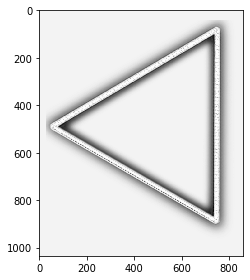

[]
1035x860


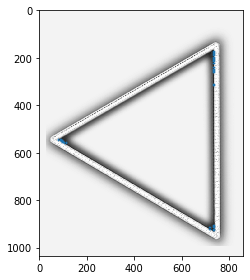

[[175, 734.0, 175.0, 735]]
[[175.0, 735, 175, 735.0]]
[[175, 734.0, 175.0, 735]]
[[175, 735.0, 175.0, 735]]
[[185, 734.0, 183.0, 735]]
[[183.0, 735, 185, 735.0]]
[[185, 734.0, 190, 732.0]]
[[185, 735.0, 190, 736.0]]
[[190, 732.0, 195, 733.0]]
[[190, 736.0, 195, 735.0]]
[[195, 733.0, 200, 733.0]]
[[195, 735.0, 200, 735.0]]
[[200, 733.0, 205, 733.0]]
[[200, 735.0, 205, 736.0]]
[[205, 733.0, 210, 734.0]]
[[205, 736.0, 210, 735.0]]
[[210, 734.0, 214.0, 735]]
[[210, 735.0, 214.0, 735]]
[[220, 734.0, 216.0, 735]]
[[216.0, 735, 220, 735.0]]
[[220, 734.0, 224.0, 735]]
[[220, 735.0, 224.0, 735]]
[[245, 735.0, 243.0, 735]]
[[243.0, 735, 245, 735.0]]
[[245, 735.0, 250, 735.0]]
[[245, 735.0, 250, 735.0]]
[[250, 735.0, 250.0, 735]]
[[250, 735.0, 250.0, 735]]
[[260, 735.0, 259.0, 735]]
[[259.0, 735, 260, 735.0]]
[[260, 735.0, 261.0, 735]]
[[260, 735.0, 261.0, 735]]
[[315, 735.0, 315.0, 735]]
[[315.0, 735, 315, 735.0]]
[[315, 735.0, 316.0, 735]]
[[315, 735.0, 316.0, 735]]
[[545, 85.0, 544.0, 85]]
[[5

----------------------------------------
G00 X735 Y315 ; 
735.0
315.0
G00
----------------------------------------
G01 X735 Y315 ; 
735.0
315.0
G01
----------------------------------------
G00 X735 Y315 ; 
735.0
315.0
G00
----------------------------------------
G01 X735 Y316 ; 
735.0
316.0
G01
----------------------------------------
G00 X735 Y315 ; 
735.0
315.0
G00
----------------------------------------
G01 X735 Y316 ; 
735.0
316.0
G01
----------------------------------------
G00 X85 Y545 ; 
85.0
545.0
G00
----------------------------------------
G01 X85 Y544 ; 
85.0
544.0
G01
----------------------------------------
G00 X85 Y544 ; 
85.0
544.0
G00
----------------------------------------
G01 X90 Y545 ; 
90.0
545.0
G01
----------------------------------------
G00 X90 Y545 ; 
90.0
545.0
G00
----------------------------------------
G01 X90 Y545 ; 
90.0
545.0
G01
----------------------------------------
G00 X85 Y545 ; 
85.0
545.0
G00
----------------------------------------
G01 X85 Y54

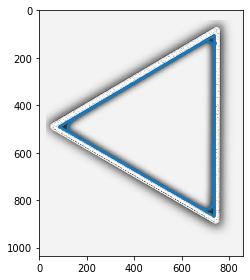

G00 X733 Y168
G01 X734 Y168
G00 X731 Y169
G01 X735 Y169
G00 X730 Y170
G01 X735 Y170
G00 X729 Y171
G01 X735 Y171
G00 X728 Y172
G01 X735 Y172
G00 X727 Y173
G01 X735 Y173
G00 X725 Y174
G01 X735 Y174
G00 X722 Y175
G01 X735 Y175
G00 X720 Y176
G01 X735 Y176
G00 X718 Y177
G01 X735 Y177
G00 X716 Y178
G01 X735 Y178
G00 X715 Y179
G01 X735 Y179
G00 X713 Y180
G01 X735 Y180
G00 X712 Y181
G01 X735 Y181
G00 X710 Y182
G01 X735 Y182
G00 X708 Y183
G01 X735 Y183
G00 X707 Y184
G01 X735 Y184
G00 X705 Y185
G01 X735 Y185
G00 X704 Y186
G01 X736 Y186
G00 X702 Y187
G01 X736 Y187
G00 X700 Y188
G01 X736 Y188
G00 X699 Y189
G01 X736 Y189
G00 X698 Y190
G01 X736 Y190
G00 X696 Y191
G01 X736 Y191
G00 X694 Y192
G01 X736 Y192
G00 X693 Y193
G01 X736 Y193
G00 X691 Y194
G01 X736 Y194
G00 X689 Y195
G01 X736 Y195
G00 X688 Y196
G01 X697 Y196
G00 X700 Y196
G01 X701 Y196
G00 X709 Y196
G01 X736 Y196
G00 X686 Y197
G01 X694 Y197
G00 X710 Y197
G01 X736 Y197
G00 X685 Y198
G01 X690 Y198
G00 X713 Y198
G01 X736 Y198
G00 X682 Y199
G01 X6

G01 X737 Y819
G00 X548 Y820
G01 X554 Y820
G00 X735 Y820
G01 X737 Y820
G00 X550 Y821
G01 X555 Y821
G00 X735 Y821
G01 X737 Y821
G00 X552 Y822
G01 X557 Y822
G00 X735 Y822
G01 X737 Y822
G00 X554 Y823
G01 X559 Y823
G00 X735 Y823
G01 X737 Y823
G00 X555 Y824
G01 X561 Y824
G00 X735 Y824
G01 X738 Y824
G00 X557 Y825
G01 X562 Y825
G00 X735 Y825
G01 X738 Y825
G00 X559 Y826
G01 X564 Y826
G00 X735 Y826
G01 X738 Y826
G00 X560 Y827
G01 X566 Y827
G00 X735 Y827
G01 X738 Y827
G00 X562 Y828
G01 X568 Y828
G00 X735 Y828
G01 X738 Y828
G00 X564 Y829
G01 X570 Y829
G00 X735 Y829
G01 X738 Y829
G00 X566 Y830
G01 X571 Y830
G00 X735 Y830
G01 X738 Y830
G00 X568 Y831
G01 X573 Y831
G00 X735 Y831
G01 X738 Y831
G00 X569 Y832
G01 X575 Y832
G00 X735 Y832
G01 X738 Y832
G00 X571 Y833
G01 X576 Y833
G00 X735 Y833
G01 X738 Y833
G00 X573 Y834
G01 X578 Y834
G00 X735 Y834
G01 X738 Y834
G00 X574 Y835
G01 X580 Y835
G00 X735 Y835
G01 X738 Y835
G00 X576 Y836
G01 X581 Y836
G00 X735 Y836
G01 X738 Y836
G00 X578 Y837
G01 X583 Y837
G00 X7

G01 X430 Y747
G00 X734 Y747
G01 X738 Y747
G00 X426 Y748
G01 X432 Y748
G00 X734 Y748
G01 X738 Y748
G00 X428 Y749
G01 X434 Y749
G00 X734 Y749
G01 X738 Y749
G00 X430 Y750
G01 X435 Y750
G00 X735 Y750
G01 X738 Y750
G00 X432 Y751
G01 X437 Y751
G00 X735 Y751
G01 X738 Y751
G00 X433 Y752
G01 X439 Y752
G00 X735 Y752
G01 X737 Y752
G00 X435 Y753
G01 X440 Y753
G00 X735 Y753
G01 X737 Y753
G00 X437 Y754
G01 X442 Y754
G00 X735 Y754
G01 X737 Y754
G00 X438 Y755
G01 X443 Y755
G00 X735 Y755
G01 X737 Y755
G00 X440 Y756
G01 X445 Y756
G00 X735 Y756
G01 X737 Y756
G00 X441 Y757
G01 X447 Y757
G00 X735 Y757
G01 X737 Y757
G00 X443 Y758
G01 X449 Y758
G00 X735 Y758
G01 X737 Y758
G00 X444 Y759
G01 X451 Y759
G00 X735 Y759
G01 X737 Y759
G00 X446 Y760
G01 X452 Y760
G00 X735 Y760
G01 X737 Y760
G00 X448 Y761
G01 X454 Y761
G00 X735 Y761
G01 X737 Y761
G00 X450 Y762
G01 X456 Y762
G00 X735 Y762
G01 X737 Y762
G00 X451 Y763
G01 X457 Y763
G00 X734 Y763
G01 X737 Y763
G00 X453 Y764
G01 X459 Y764
G00 X734 Y764
G01 X737 Y764
G00 X4

G00 X733 Y168 ; 
733.0
168.0
G00
----------------------------------------
G01 X734 Y168 ; 
734.0
168.0
G01
----------------------------------------
G00 X731 Y169 ; 
731.0
169.0
G00
----------------------------------------
G01 X735 Y169 ; 
735.0
169.0
G01
----------------------------------------
G00 X730 Y170 ; 
730.0
170.0
G00
----------------------------------------
G01 X735 Y170 ; 
735.0
170.0
G01
----------------------------------------
G00 X729 Y171 ; 
729.0
171.0
G00
----------------------------------------
G01 X735 Y171 ; 
735.0
171.0
G01
----------------------------------------
G00 X728 Y172 ; 
728.0
172.0
G00
----------------------------------------
G01 X735 Y172 ; 
735.0
172.0
G01
----------------------------------------
G00 X727 Y173 ; 
727.0
173.0
G00
----------------------------------------
G01 X735 Y173 ; 
735.0
173.0
G01
----------------------------------------
G00 X725 Y174 ; 
725.0
174.0
G00
----------------------------------------
G01 X735 Y174 ; 
735.0
174.0
G01
-----

----------------------------------------
G01 X668 Y210 ; 
668.0
210.0
G01
----------------------------------------
G00 X725 Y210 ; 
725.0
210.0
G00
----------------------------------------
G01 X736 Y210 ; 
736.0
210.0
G01
----------------------------------------
G00 X662 Y211 ; 
662.0
211.0
G00
----------------------------------------
G01 X666 Y211 ; 
666.0
211.0
G01
----------------------------------------
G00 X725 Y211 ; 
725.0
211.0
G00
----------------------------------------
G01 X736 Y211 ; 
736.0
211.0
G01
----------------------------------------
G00 X661 Y212 ; 
661.0
212.0
G00
----------------------------------------
G01 X664 Y212 ; 
664.0
212.0
G01
----------------------------------------
G00 X726 Y212 ; 
726.0
212.0
G00
----------------------------------------
G01 X736 Y212 ; 
736.0
212.0
G01
----------------------------------------
G00 X658 Y213 ; 
658.0
213.0
G00
----------------------------------------
G01 X662 Y213 ; 
662.0
213.0
G01
--------------------------------------

----------------------------------------
G00 X613 Y239 ; 
613.0
239.0
G00
----------------------------------------
G01 X617 Y239 ; 
617.0
239.0
G01
----------------------------------------
G00 X732 Y239 ; 
732.0
239.0
G00
----------------------------------------
G01 X736 Y239 ; 
736.0
239.0
G01
----------------------------------------
G00 X612 Y240 ; 
612.0
240.0
G00
----------------------------------------
G01 X615 Y240 ; 
615.0
240.0
G01
----------------------------------------
G00 X732 Y240 ; 
732.0
240.0
G00
----------------------------------------
G01 X736 Y240 ; 
736.0
240.0
G01
----------------------------------------
G00 X610 Y241 ; 
610.0
241.0
G00
----------------------------------------
G01 X613 Y241 ; 
613.0
241.0
G01
----------------------------------------
G00 X732 Y241 ; 
732.0
241.0
G00
----------------------------------------
G01 X736 Y241 ; 
736.0
241.0
G01
----------------------------------------
G00 X608 Y242 ; 
608.0
242.0
G00
--------------------------------------

----------------------------------------
G01 X736 Y266 ; 
736.0
266.0
G01
----------------------------------------
G00 X565 Y267 ; 
565.0
267.0
G00
----------------------------------------
G01 X568 Y267 ; 
568.0
267.0
G01
----------------------------------------
G00 X732 Y267 ; 
732.0
267.0
G00
----------------------------------------
G01 X735 Y267 ; 
735.0
267.0
G01
----------------------------------------
G00 X564 Y268 ; 
564.0
268.0
G00
----------------------------------------
G01 X567 Y268 ; 
567.0
268.0
G01
----------------------------------------
G00 X732 Y268 ; 
732.0
268.0
G00
----------------------------------------
G01 X735 Y268 ; 
735.0
268.0
G01
----------------------------------------
G00 X561 Y269 ; 
561.0
269.0
G00
----------------------------------------
G01 X565 Y269 ; 
565.0
269.0
G01
----------------------------------------
G00 X732 Y269 ; 
732.0
269.0
G00
----------------------------------------
G01 X735 Y269 ; 
735.0
269.0
G01
--------------------------------------

----------------------------------------
G00 X733 Y295 ; 
733.0
295.0
G00
----------------------------------------
G00 X515 Y296 ; 
515.0
296.0
G00


TclError: invalid command name ".!canvas"

0

In [8]:
mainFrame = MainWindow(None, "2D Plotter")
mainFrame.CenterOnScreen()
mainFrame.SetFocus()
mainFrame.Raise()
app.MainLoop()